In [287]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import sympy

import def_all_CRNs as CRNs
from dae_finder import (
        AlgModelFinder,
        PolyFeatureMatrix,
        add_noise_to_df,
        get_refined_lib,
        sequentialThLin,
        smooth_data,
)

### Discovery of Algebraic Relationships

In [288]:
num_points = 1000
noise_perc = 15
t_final = 4

In [289]:
# 1) Make data
clean_data = CRNs.make_CRN1(5, num_points, t_final)
clean_df = pd.DataFrame(clean_data, columns=['t', 'A', 'B', 'E1', 'AE1'])

data_matrix_df_list = [clean_df.iloc[i:i+num_points].reset_index(drop=True) for i in range(0, len(clean_df), num_points)]

tSolve = list(data_matrix_df_list[0]['t'])
num_time_points = len(tSolve)

# 2) Noise data
for ind, data_matrix_ in enumerate(data_matrix_df_list):
        t_exact = data_matrix_["t"]
        noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=8) # Use trial as RNG seed
        noisy_data_df["t"] = t_exact
        data_matrix_df_list[ind] = noisy_data_df

data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)

data_matrix_features = data_matrix_df_list[0].columns

# 3) Smooth noisy data
data_matrix_smooth_df_list = [
    smooth_data(data_matrix[:num_points],
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=1,
                polyorder=2,
                window_smooth=None)[10:-10] #trimming zero derivatives near end points
    for data_matrix in data_matrix_df_list]

if len(data_matrix_smooth_df_list) == 1:
        data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
        data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[['A', 'B', 'E1', 'AE1']]


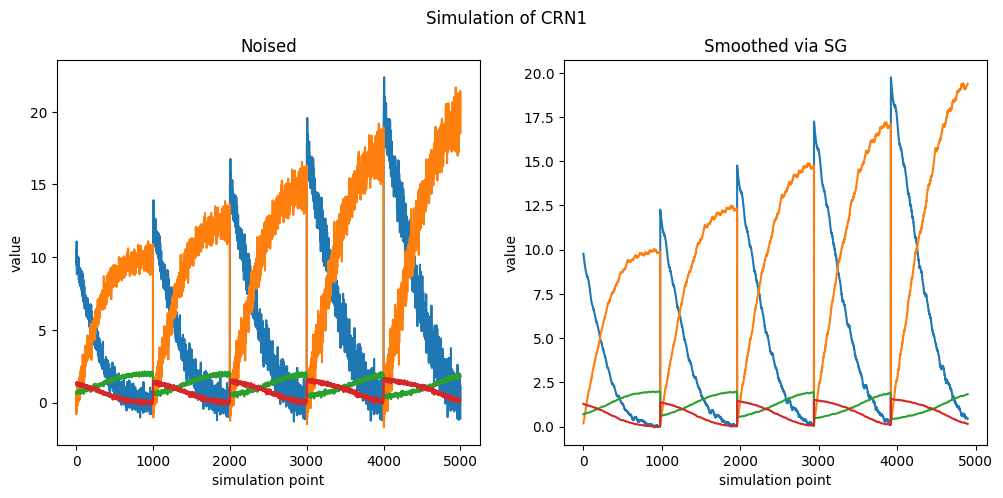

In [290]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axes[0].plot(data_matrix_df_appended.drop('t', axis=1))
axes[0].set_title("Noised")

axes[1].plot(data_matrix_df_new)
axes[1].set_title("Smoothed via SG")

axes[0].set_xlabel("simulation point")
axes[1].set_xlabel("simulation point")

axes[0].set_ylabel("value")
axes[1].set_ylabel("value")

# Shared title
fig.suptitle("Simulation of CRN1")

# Show the plot
plt.show()

In [291]:
# 4) Make lib
poly_degree = 2

poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))
print("Full candidate library has the following features: {}".format(list(candidate_lib_full.columns)))

Degree of library: 2
# terms in the library: 14
Full candidate library has the following features: ['A', 'B', 'E1', 'AE1', 'A^2', 'A B', 'A E1', 'A AE1', 'B^2', 'B E1', 'B AE1', 'E1^2', 'E1 AE1', 'AE1^2']


In [292]:
# 5) Make feats
feat_list = ['A', 'B', 'E1', 'AE1']
feat_list_str = ", ".join(feat_list)
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [293]:
# 6) Find first rel (mass conservation)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(data_matrix_df_new, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 0 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


['E1', 'AE1']

In [294]:
# 7) Remove first rel (mass conservation)
features_to_remove, refined_candid_lib = get_refined_lib({E1}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['E1 AE1', 'B E1', 'A E1', 'E1^2', 'E1']
# terms in the library: 9
Candidate library has the following features: ['A', 'B', 'AE1', 'A^2', 'A B', 'A AE1', 'B^2', 'B AE1', 'AE1^2']


In [295]:
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


['A AE1', 'A', 'AE1', 'A^2', 'AE1^2']

In [296]:
# 9) Remove second rel (QSSA)
features_to_remove, refined_candid_lib = get_refined_lib({A*AE1, E1}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['E1 AE1', 'B E1', 'A E1', 'A AE1', 'E1^2', 'E1']
# terms in the library: 8
Candidate library has the following features: ['A', 'B', 'AE1', 'A^2', 'A B', 'B^2', 'B AE1', 'AE1^2']


In [297]:
# 10) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


['A', 'AE1', 'A^2', 'AE1^2']

In [298]:
features_to_remove, refined_candid_lib = get_refined_lib({E1, A*AE1, AE1**2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['AE1^2', 'E1 AE1', 'B E1', 'A E1', 'A AE1', 'E1^2', 'E1']
# terms in the library: 7
Candidate library has the following features: ['A', 'B', 'AE1', 'A^2', 'A B', 'B^2', 'B AE1']


In [299]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations


['A', 'AE1', 'A^2', 'A B', 'B AE1']

In [300]:
features_to_remove, refined_candid_lib = get_refined_lib({E1, A*AE1, AE1**2, A**2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['AE1^2', 'A^2', 'E1 AE1', 'B E1', 'A E1', 'A AE1', 'E1^2', 'E1']
# terms in the library: 6
Candidate library has the following features: ['A', 'B', 'AE1', 'A B', 'B^2', 'B AE1']


In [301]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations


['B', 'AE1', 'A B', 'B^2', 'B AE1']

In [302]:
features_to_remove, refined_candid_lib = get_refined_lib({E1, A*AE1, AE1**2, A**2, B*AE1}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['B AE1', 'E1 AE1', 'B E1', 'A E1', 'E1^2', 'E1', 'AE1^2', 'A^2', 'A AE1']
# terms in the library: 5
Candidate library has the following features: ['A', 'B', 'AE1', 'A B', 'B^2']


### SVD Analysis

In [303]:
features_to_remove = {E1}
features_to_remove, refined_candid_lib_1 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E1, A*AE1,}
features_to_remove, refined_candid_lib_2 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E1, A*AE1, AE1**2,}
features_to_remove, refined_candid_lib_3 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E1, A*AE1, AE1**2,A**2}
features_to_remove, refined_candid_lib_4 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

"""features_to_remove = {E1, A*AE1, AE1**2, A**2, B*AE1}
features_to_remove, refined_candid_lib_5 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E1, A*AE1, AE1**2, A**2, B*AE1, A*B}
features_to_remove, refined_candid_lib_6 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)"""

'features_to_remove = {E1, A*AE1, AE1**2, A**2, B*AE1}\nfeatures_to_remove, refined_candid_lib_5 = get_refined_lib(features_to_remove, data_matrix_df_new,\n                                                  candidate_lib_full, get_dropped_feat=True)\n\nfeatures_to_remove = {E1, A*AE1, AE1**2, A**2, B*AE1, A*B}\nfeatures_to_remove, refined_candid_lib_6 = get_refined_lib(features_to_remove, data_matrix_df_new,\n                                                  candidate_lib_full, get_dropped_feat=True)'

In [304]:
# Perform Singular Value Decomposition (SVD) on the candidate libraries
U_full, s_full, Vt_full = np.linalg.svd(candidate_lib_full, full_matrices=False)
U_refined_1, s_refined_1, Vt_refined_1 = np.linalg.svd(refined_candid_lib_1, full_matrices=False)
U_refined_2, s_refined_2, Vt_refined_2 = np.linalg.svd(refined_candid_lib_2, full_matrices=False)
U_refined_3, s_refined_3, Vt_refined_3 = np.linalg.svd(refined_candid_lib_3, full_matrices=False)
U_refined_4, s_refined_4, Vt_refined_4 = np.linalg.svd(refined_candid_lib_4, full_matrices=False)

# Calculate the explained variance ratio for the candidate libraries
explained_variance_ratio_full = (s_full ** 2) / np.sum(s_full ** 2)
explained_variance_ratio_refined_1 = (s_refined_1 ** 2) / np.sum(s_refined_1 ** 2)
explained_variance_ratio_refined_2 = (s_refined_2 ** 2) / np.sum(s_refined_2 ** 2)
explained_variance_ratio_refined_3 = (s_refined_3 ** 2) / np.sum(s_refined_3 ** 2)
explained_variance_ratio_refined_4 = (s_refined_4 ** 2) / np.sum(s_refined_4 ** 2)

In [305]:
# Calc cond num for each iter
cond_numbers = [np.linalg.cond(lib) for lib in [candidate_lib_full, refined_candid_lib_1, refined_candid_lib_2,
                                                 refined_candid_lib_3, refined_candid_lib_4,
                                                ]]

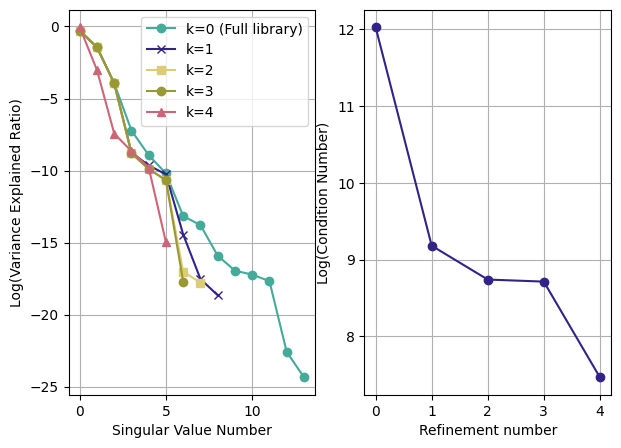

In [306]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

# Plot the log of the explained variance ratio for all libraries in the first subplot
ax1.plot(np.log(explained_variance_ratio_full), marker='o', label='k=0 (Full library)', color="#44AA99")
ax1.plot(np.log(explained_variance_ratio_refined_1), marker='x', label='k=1', color="#332288")
ax1.plot(np.log(explained_variance_ratio_refined_2), marker='s', label='k=2', color="#DDCC77")
ax1.plot(np.log(explained_variance_ratio_refined_3), marker='o', label='k=3', color="#999933")
ax1.plot(np.log(explained_variance_ratio_refined_4), marker='^', label='k=4', color="#CC6677")

ax1.set_xlabel('Singular Value Number')
ax1.set_ylabel('Log(Variance Explained Ratio)')
# ax1.set_title('Log(Variance Explained Ratio) vs Singular Value Number')
ax1.legend()
ax1.grid(True)

# Plot the log of condition numbers in the second subplot
ax2.plot(np.log(cond_numbers), marker='o', color="#332288")
ax2.set_ylabel('Log(Condition Number)')
ax2.set_xlabel('Refinement number')
# ax2.set_title('Log of Condition Numbers for Candidate and Refined Libraries')
ax2.grid(True)

### Discovery of Dynamic Relationships + Parameter Estimation

In [307]:
# 1) dB/dt
features_to_remove, refined_candid_lib = get_refined_lib({E1, A*AE1}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

refined_candid_lib['d(B) /dt'] = data_matrix_df_smooth_appended['d(B) /dt']
algebraic_model_th.fit(X=refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models()['d(B) /dt']

best_rhs = best_model.to_frame().index[best_model.to_frame().iloc[:, 0] != 0][:-1].to_list()
best_relationship = best_rhs
print(best_relationship)

Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
['AE1', 'd(B) /dt']


In [308]:
lin_model = LinearRegression()

best_relation_lhs = 'd(B) /dt'
best_relation_rhs = [i for i in best_relationship if i != 'd(B) /dt']

lin_model.fit(refined_candid_lib[best_relation_rhs], refined_candid_lib[best_relation_lhs])

d_B = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d_B = {k: v for k, v in d_B.items() if abs(v) >= 0.1} # filter out small pars

d_B['LHS'] = best_relation_lhs
d_B['intercept'] = lin_model.intercept_ if abs(lin_model.intercept_) >= 0.1 else 0.

In [309]:
d_B

{'AE1': np.float64(5.072995634650399), 'LHS': 'd(B) /dt', 'intercept': 0.0}

/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


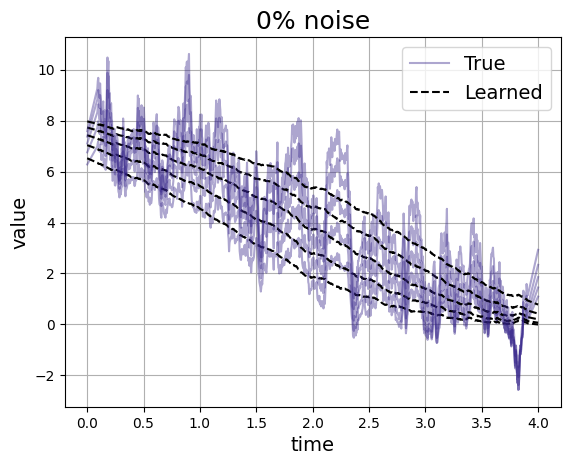

In [310]:

AE1_ = data_matrix_df_smooth_appended['AE1']
dB_ = data_matrix_df_smooth_appended['d(B) /dt']

mdB_ = np.array_split(dB_, 5)
mAE1_ = np.array_split(AE1_, 5)

for i in range(5):
    if i == 0:
        plt.plot(np.linspace(0, 4, 980), mdB_[i], label='True', color='#332288', alpha=0.4)
    else:
         plt.plot(np.linspace(0, 4, 980), mdB_[i], label=None, color='#332288', alpha=0.4)

    if i == 0:
        if d_B['LHS'] == 'AE1':
            plt.plot(np.linspace(0, 4, 980), (1/d_B['d(B) /dt'])*mAE1_[i], '--', color='black', label='Learned')
        else:
            plt.plot(np.linspace(0, 4, 980), d_B['AE1']*mAE1_[i], '--', color='black', label='Learned')
    else:
        if d_B['LHS'] == 'AE1':
            plt.plot(np.linspace(0, 4, 980), (1/d_B['d(B) /dt'])*mAE1_[i], '--', color='black', label=None)
        else:
            plt.plot(np.linspace(0, 4, 980), d_B['AE1']*mAE1_[i], '--', color='black', label=None)

    plt.title("0% noise", fontsize=18)
    plt.grid(True)

    plt.xlabel("time", fontsize=14)
    plt.ylabel("value", fontsize=14)
    plt.legend(fontsize=14)

# Show the plot
plt.show()